# <center> Basic epidemic models <center>

## Helpers

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from scipy.optimize import minimize
from time import time

In [2]:
# To compute the time to the epidemics peak
def peak(L):
    for i in range(len(L)):
        if L[i+1]<L[i]:
            return i
    return "no peak"

## SIR model

In this first approach, we consider three types of people:

- the __susceptible__ people: they are not immune thus they are likely to be infected
- the __infected__ people: they carry the virus and can infect the susceptible people
- the __recovered__ people: they've already been infected and then they recovered or died. Either case, they can't get infected anymore.

The ODE that we need to solve are as follow:

$$
\left\{
\begin{array}{r c l}
S'(t) & = & -pS(t)I(t) \\
I'(t) & = & pS(t)I(t) - I(t)/d \\
R'(t) & = & I(t)/d
\end{array}
\right.
$$

Where:

- *p* is the __infection rate__: depends on the number of contact between infected and susceptible people, and the probability for a contact to be contagious.
- *d* is the __contagiousness duration__: the number of days people stay contagious.

In [3]:
# SIR model simulation
def SIR(I0, rho, c, d, T):
    p = rho*c # Infection rate
    S, I, R = 1-I0, I0, 0
    S_list, I_list, R_list = [S], [I], [R]
    for i in range(T):
        S, I, R = S - p*S*I, I + p*S*I - I/d, R + I/d
        S_list.append(S)
        I_list.append(I)
        R_list.append(R)
    return S_list, I_list, R_list

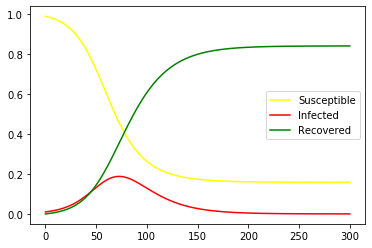

Cumulative number of infected people: 84.1%
Duration before the peak: 73


In [4]:
# Simulation parameters
I0 = .01 # Initial number of infected people
rho = .04 # Probabibility of contagion for an interaction
c = 3 # Number of contacts per people per day
d = 18 # Contagiousness duration (days) 
T = 300 # Study duration (days)

# Run simulation
S_list, I_list, R_list = SIR(I0, rho, c, d, T)

# Plot results
plt.plot(S_list, label='Susceptible', color='yellow')
plt.plot(I_list, label='Infected', color='red')
plt.plot(R_list, label='Recovered', color='green')
plt.legend()
plt.show()

print("Cumulative number of infected people: {}%".format(round(100*R_list[-1], 1)))
print("Duration before the peak: {}".format(peak(I_list)))

## SEIR model

In this second approach, we consider three types of people:

- the __susceptible__ people: they are not immune thus they are likely to be infected
- the __exposed__ people: they carry the virus but they don't have any symptoms
- the __infected__ people: they carry the virus and can infect the susceptible people, but they know thay are sick as they are enough advanced to have symptoms
- the __recovered__ people: they've already been infected and then they recovered or died. Either case, they can't get infected anymore.

The ODE that we need to solve are as follow:

$$
\left\{
\begin{array}{r c l}
S'(t) & = & -p_eS(t)E(t) - p_iS(t)I(t) \\
E'(t) & = & p_eS(t)E(t) + p_iS(t)I(t) - E(t)/d_e \\
I'(t) & = & E(t)/d_e - I(t)/d_i \\
R'(t) & = & I(t)/d_i
\end{array}
\right.
$$

Where:

- $p_e$ is the __exposition rate__: depends on the number of contact between exposed and susceptible people, and the probability for a contact to be contagious.
- $p_i$ is the __infection rate__: depends on the number of contact between infected and susceptible people, and the probability for a contact to be contagious.
- $d_e$ is the __exposition duration__: the number of days people stay contagious without any symptom.
- $d_i$ is the __infection duration__: the number of days people stay contagious with symptoms.

In [3]:
# SEIR simulation
def SEIR(E0, I0, pe, pi, de, di, T):
    S, E, I, R = 1-E0-I0, E0, I0, 0
    S_list, E_list, I_list, R_list = [S], [E], [I], [R]
    for i in range(T):
        S, E, I, R = S - pe*S*E - pi*S*I, E + pe*S*E + pi*S*I - E/de, I + E/de - I/di, R + I/di
        S_list.append(S)
        E_list.append(E)
        I_list.append(I)
        R_list.append(R)
    return S_list, E_list, I_list, R_list

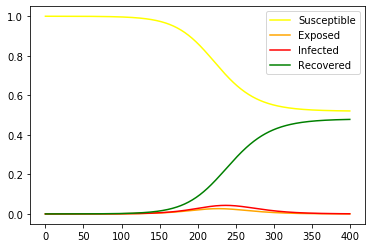

Cumulative number of infected people: 0.47809741537306305
Duration before the peak: 237


In [6]:
# Simulation parameters
E0 = .000015 # Initial number of exposed people
I0 = .00001 # Initial number of infected people
pe = .16
pi = .04
de = 6 # Exposition duration (days)
di = 10 # Infection duration (days)
T = 400 # Study duration (days)

# Run simulation
S_list, E_list, I_list, R_list = SEIR(E0, I0, pe, pi, de, di, T)

# Plot results
plt.plot(S_list, label='Susceptible', color='yellow')
plt.plot(E_list, label='Exposed', color='orange')
plt.plot(I_list, label='Infected', color='red')
plt.plot(R_list, label='Recovered', color='green')
plt.legend()
plt.show()

print("Cumulative number of infected people: {}".format(R_list[-1]))
print("Duration before the peak: {}".format(peak(I_list)))

## Fitting SEIR model to Novel data (Kaggle)

In this part we will try to fit the SEIR model to some real data found on kaggle.com. The parameters we need to fit are $p_e$ and $p_i$. 

The most reliable data we have is the evolution of I(t). We have pulled out the evolution of the number of infected people in France between 03/15 and 04/01. The series is called $I_{ref}$ (*cf.* 3 cells below). At each optimization step, the SEIR model is simulated and returns $I_{list}$. Then we can compute the cost function: 
$$J(I_{list}, I_{ref})=\frac{||I_{list}-I_{ref}||_{L^2}}{||I_{ref}||_{L^2}} + J_{reg}$$

Where $J_{reg}$ is the Tikhonov regularization term:
$$J_{reg} = \gamma ||I_{list}||_{L^2}$$

The penalization factor $\gamma$ has to be optimized as well. Indeed, if $\gamma<<1$ then there almost no regularization as $J_{reg}\simeq0$. In this case, the model will perfectly fit the observations but it will overestimate the epidemics. If $\gamma>>1$ then the epidemics will be minimized and smooth but it won't fit the data anymore.

The optimization method is a simple gridsearch.

In [24]:
# Cost function computation 
def J(x, I_ref, regularization_methods=None, T=200):
    
    pe, pi, exposition_ratio = x[0], x[1], x[2]
    
    I0, E0 = I_ref[0], exposition_ratio*I_ref[0]
    if 'tikhonov' in regularization_methods or 'max' in regularization_methods:
        S_list, E_list, I_list, R_list = SEIR(E0, I0, pe, pi, 6, 10, T)
    else:
        S_list, E_list, I_list, R_list = SEIR(E0, I0, pe, pi, 6, 10, len(I_ref)-1)
    I_list = np.array(I_list)
    err = np.linalg.norm(I_ref-I_list[:len(I_ref)])/np.linalg.norm(I_ref)
    
    reg = 0
    if 'pe' in regularization_methods:
        reg += regularization_methods['pe']*pe
    if 'pi' in regularization_methods:
        reg += regularization_methods['pi']*pi
    if 'max' in regularization_methods:
        reg += regularization_methods['max']*np.max(I_list)
    if 'tikhonov' in regularization_methods:
        reg += regularization_methods['tikhonov']*np.linalg.norm(I_list)
    
    return err + reg

In [25]:
# Grid search for best parameters
def grid_search(I_ref, grid_pe, grid_pi, grid_exposition_ratio, regularization_methods=None, T=200):
    best_J = float('inf')
    for exposition_ratio in grid_exposition_ratio:
        for pe in grid_pe:
            for pi in grid_pi:
                new_J = J(I_ref, pe, pi, exposition_ratio, regularization_methods, T)
                if new_J < best_J:
                    best_J = new_J
                    best_pe, best_pi, best_exposition_ratio = pe, pi, exposition_ratio
    return best_pe, best_pi, best_exposition_ratio, best_J

In [16]:
def random_sample_minimize(J, bounds, extra_parameters, n_grid=1000, n_iter=25, local_method='SLSQP'):

    t0 = time()

    pe_bounds, pi_bounds, exposition_ratio_bounds = bounds[0], bounds[1], bounds[2]

    pe_choice = np.random.choice(np.linspace(*pe_bounds, n_grid), n_iter)
    pi_choice = np.random.choice(np.linspace(*pi_bounds, n_grid), n_iter)
    exposition_ratio_choice = np.random.choice(np.linspace(*exposition_ratio_bounds, n_grid), n_iter)

    best_results = {'fun': float('inf')}
    for i in range(n_iter):

        pe, pi, exposition_ratio = pe_choice[i], pi_choice[i], exposition_ratio_choice[i]
        x0 = np.array([pe, pi, exposition_ratio])

        new_results = minimize(
            J, 
            x0, 
            extra_parameters, 
            method=local_method,
            bounds=[pe_bounds, pi_bounds, exposition_ratio_bounds]
        )

        if new_results['success'] and new_results['fun'] < best_results['fun']:
            
            best_results = new_results
    
    best_results['runtime'] = time()-t0
    
    return best_results

In [4]:
# Plot results (two plots: how the simulation fits to the reality (left subplot) and how it extrapolates (right subplot))
def plot_results(I_ref, S_list, E_list, I_list, R_list):
    plt.rcParams['figure.figsize'] = [10, 3]
    plt.subplot(1,2,1)
    plt.plot(I_ref, linestyle='None', marker='x', c='blue', label='I(t) (reference data)')
    plt.plot(I_list[:len(I_ref)], c='red', label='I(t) (fitted SEIR model)')
    plt.title('Similarity with the reference data')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(I_ref, linestyle='None', marker='x', label='I(t) (reference data)')
    plt.plot(I_list, c='red', label='I(t) (fitted SEIR model)')
    plt.plot(S_list, c='yellow', label='S(t) (fitted SEIR model)')
    plt.plot(E_list, c='orange', label='E(t) (fitted SEIR model)')
    plt.plot(R_list, c='green', label='R(t) (fitted SEIR model)')
    plt.title('Extrapolation')
    plt.legend()
    plt.tight_layout()
    plt.show()

- Utiliser in-built pour min J : OK
- Tester 0<gamma<.5 et 1.2<gamma<1.7 : 
- Expliquer prk on arrive à R=1 et S=0 sans reg, et pas dans SIR/SEIR théoriques : OK
- Fitter sur les R(t) : 

gamma = 0.0
     fun: 0.03685942264023701
     jac: array([-5.73880970e-05,  1.04129883e-02, -6.10342249e-06])
 message: 'Optimization terminated successfully.'
    nfev: 121
     nit: 23
    njev: 23
 runtime: 13.096889972686768
  status: 0
 success: True
       x: array([2.75992726e-01, 1.00004093e-10, 1.77129705e+00])


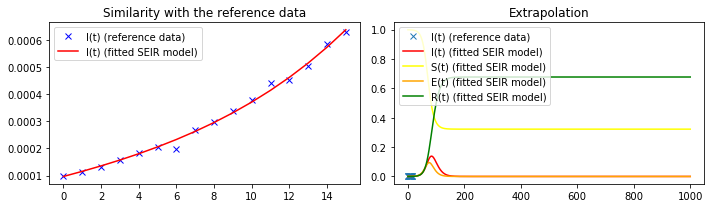

Cumulative number of infected people: 67.8%
Duration before the peak: 84
gamma = 0.10204081632653061
     fun: 0.11574705482829574
     jac: array([ 2.14974396e-04,  3.18108382e-01, -1.99452043e-05])
 message: 'Optimization terminated successfully.'
    nfev: 110
     nit: 21
    njev: 21
 runtime: 8.811700105667114
  status: 0
 success: True
       x: array([2.68855169e-01, 1.00692586e-10, 1.86408168e+00])


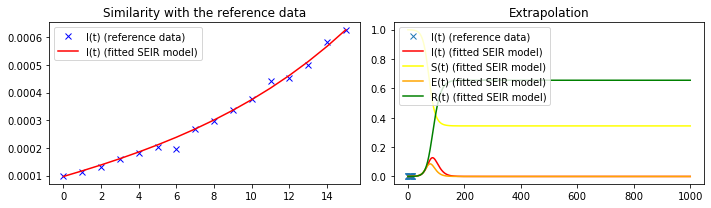

Cumulative number of infected people: 65.6%
Duration before the peak: 87
gamma = 0.20408163265306123
     fun: 0.18867273938672427
     jac: array([-1.92262232e-04,  7.13980859e-01, -5.12506813e-05])
 message: 'Optimization terminated successfully.'
    nfev: 128
     nit: 24
    njev: 24
 runtime: 9.295048236846924
  status: 0
 success: True
       x: array([2.55314266e-01, 1.00000000e-10, 2.04965718e+00])


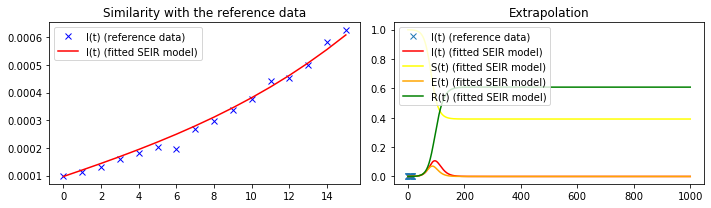

Cumulative number of infected people: 60.9%
Duration before the peak: 95
gamma = 0.30612244897959184
     fun: 0.2129537187169437
     jac: array([-1.16364583e-02,  1.39722330e+00, -6.57366589e-04])
 message: 'Optimization terminated successfully.'
    nfev: 86
     nit: 16
    njev: 16
 runtime: 10.29038691520691
  status: 0
 success: True
       x: array([1.77847338e-01, 1.00000072e-10, 3.33351018e+00])


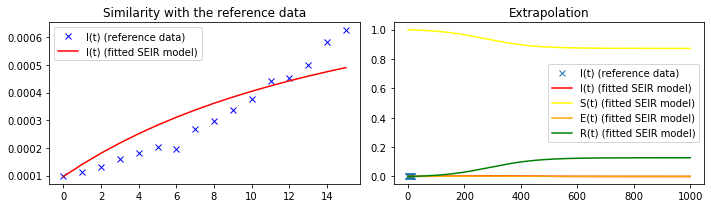

Cumulative number of infected people: 12.7%
Duration before the peak: 288
gamma = 0.40816326530612246
     fun: 0.21707627207571226
     jac: array([2.09560636e-02, 1.46393888e+00, 2.10419297e-04])
 message: 'Optimization terminated successfully.'
    nfev: 92
     nit: 17
    njev: 17
 runtime: 9.351834774017334
  status: 0
 success: True
       x: array([1.72723155e-01, 1.00002278e-10, 3.42878222e+00])


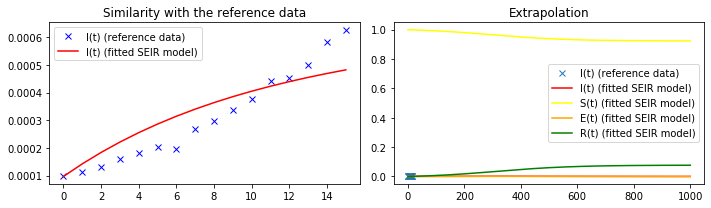

Cumulative number of infected people: 7.7%
Duration before the peak: 311
gamma = 0.5102040816326531
     fun: 0.21956066193429127
     jac: array([1.90739911e-02, 1.47189359e+00, 1.53819099e-04])
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 18
    njev: 18
 runtime: 7.6698079109191895
  status: 0
 success: True
       x: array([1.70667048e-01, 1.00000530e-10, 3.46674191e+00])


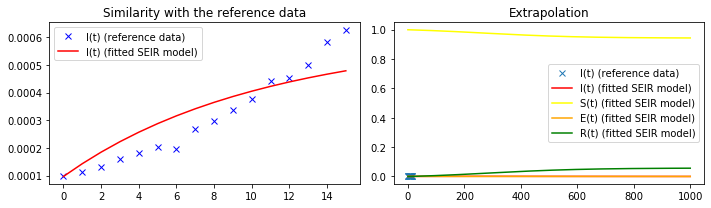

Cumulative number of infected people: 5.6%
Duration before the peak: 284
gamma = 0.6122448979591837
     fun: 0.22143195824277853
     jac: array([-6.63381070e-05,  1.44802483e+00, -3.76999378e-06])
 message: 'Optimization terminated successfully.'
    nfev: 107
     nit: 20
    njev: 20
 runtime: 9.280788898468018
  status: 0
 success: True
       x: array([1.69493501e-01, 1.00071722e-10, 3.48816611e+00])


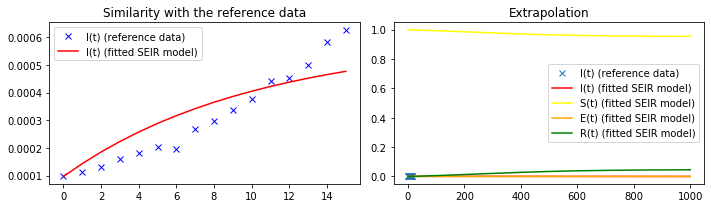

Cumulative number of infected people: 4.6%
Duration before the peak: 240
gamma = 0.7142857142857143
     fun: 0.22298866624940533
     jac: array([-1.56655908e-04,  1.45032016e+00, -5.03472984e-06])
 message: 'Optimization terminated successfully.'
    nfev: 99
     nit: 18
    njev: 18
 runtime: 10.635473012924194
  status: 0
 success: True
       x: array([1.68698323e-01, 1.00000016e-10, 3.50249918e+00])


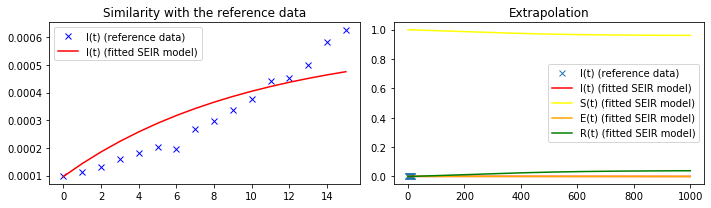

Cumulative number of infected people: 3.9%
Duration before the peak: 192
gamma = 0.8163265306122449
     fun: 0.22435344173640318
     jac: array([5.79010695e-04, 1.45215743e+00, 4.18927521e-05])
 message: 'Optimization terminated successfully.'
    nfev: 106
     nit: 20
    njev: 20
 runtime: 7.3652098178863525
  status: 0
 success: True
       x: array([1.68099392e-01, 1.00000016e-10, 3.51332875e+00])


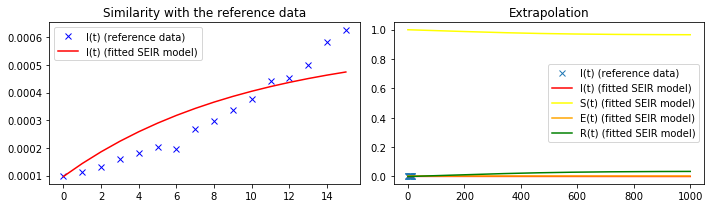

Cumulative number of infected people: 3.4%
Duration before the peak: 144
gamma = 0.9183673469387755
     fun: 0.22558780552776214
     jac: array([-8.60651955e-04,  1.45181194e+00, -1.55903399e-05])
 message: 'Optimization terminated successfully.'
    nfev: 59
     nit: 11
    njev: 11
 runtime: 6.6383984088897705
  status: 0
 success: True
       x: array([1.67617376e-01, 1.00000678e-10, 3.52162978e+00])


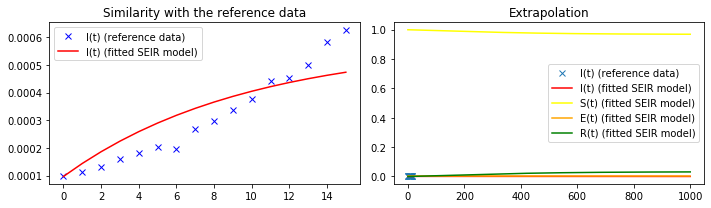

Cumulative number of infected people: 3.1%
Duration before the peak: 100
gamma = 1.0204081632653061
     fun: 0.22672698717510203
     jac: array([-1.94909051e-04,  1.45336423e+00, -6.38142228e-06])
 message: 'Optimization terminated successfully.'
    nfev: 87
     nit: 15
    njev: 15
 runtime: 9.2571120262146
  status: 0
 success: True
       x: array([1.67213822e-01, 1.00000645e-10, 3.52869814e+00])


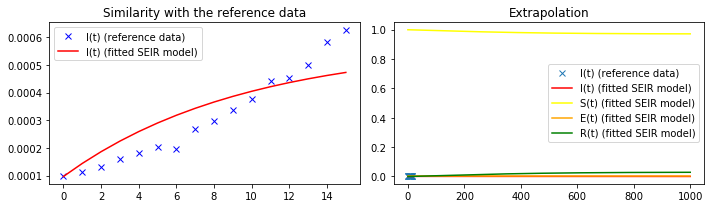

Cumulative number of infected people: 2.8%
Duration before the peak: 67
gamma = 1.1224489795918369
     fun: 0.2277931080067105
     jac: array([-3.39820236e-03,  1.44786974e+00,  2.58162618e-05])
 message: 'Optimization terminated successfully.'
    nfev: 103
     nit: 18
    njev: 18
 runtime: 14.091341972351074
  status: 0
 success: True
       x: array([1.66855873e-01, 1.00001082e-10, 3.53500969e+00])


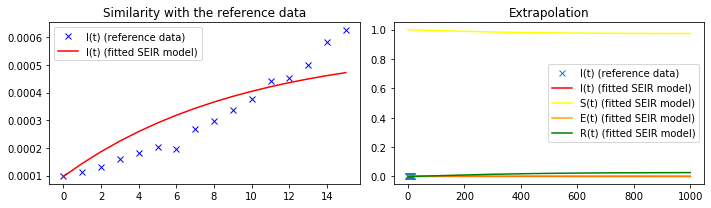

Cumulative number of infected people: 2.6%
Duration before the peak: 54
gamma = 1.2244897959183674
     fun: 0.22880095833937045
     jac: array([ 1.49221271e-02,  1.48448892e+00, -3.02638859e-04])
 message: 'Optimization terminated successfully.'
    nfev: 106
     nit: 20
    njev: 20
 runtime: 13.362585067749023
  status: 0
 success: True
       x: array([1.66552891e-01, 1.00244465e-10, 3.54009486e+00])


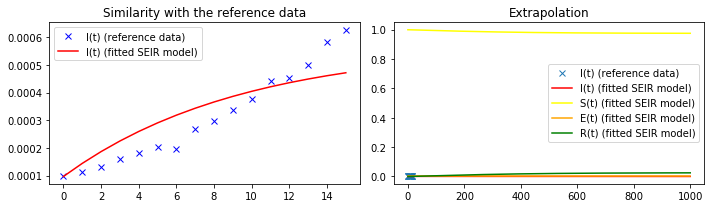

Cumulative number of infected people: 2.5%
Duration before the peak: 48
gamma = 1.3265306122448979
     fun: 0.22976106958355463
     jac: array([3.52590904e-03, 1.45963836e+00, 2.61627138e-05])
 message: 'Optimization terminated successfully.'
    nfev: 109
     nit: 20
    njev: 20
 runtime: 11.469802856445312
  status: 0
 success: True
       x: array([1.66276564e-01, 1.00000121e-10, 3.54486669e+00])


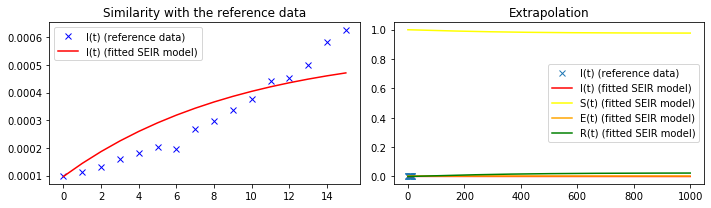

Cumulative number of infected people: 2.3%
Duration before the peak: 45
gamma = 1.4285714285714286
     fun: 0.23068109669253997
     jac: array([-3.16018034e-02,  1.40344561e+00, -7.90841877e-05])
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 18
    njev: 18
 runtime: 6.8268492221832275
  status: 0
 success: True
       x: array([1.66016150e-01, 1.00000000e-10, 3.54917903e+00])


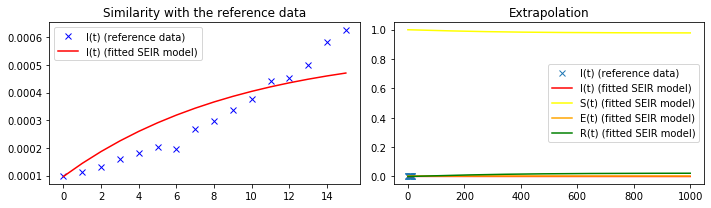

Cumulative number of infected people: 2.2%
Duration before the peak: 43
gamma = 1.5306122448979593
     fun: 0.23156690363585367
     jac: array([-1.65125169e-03,  1.45188092e+00, -2.03941017e-05])
 message: 'Optimization terminated successfully.'
    nfev: 108
     nit: 19
    njev: 19
 runtime: 10.198410987854004
  status: 0
 success: True
       x: array([1.65774079e-01, 1.00000098e-10, 3.55317252e+00])


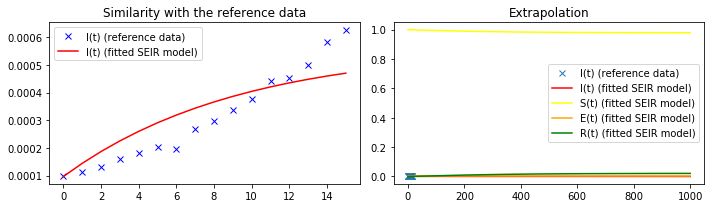

Cumulative number of infected people: 2.1%
Duration before the peak: 41
gamma = 1.6326530612244898
     fun: 0.23242303566609554
     jac: array([-4.01234999e-03,  1.44767231e+00, -1.14049762e-05])
 message: 'Optimization terminated successfully.'
    nfev: 117
     nit: 22
    njev: 22
 runtime: 21.742296934127808
  status: 0
 success: True
       x: array([1.65547635e-01, 1.00000000e-10, 3.55698790e+00])


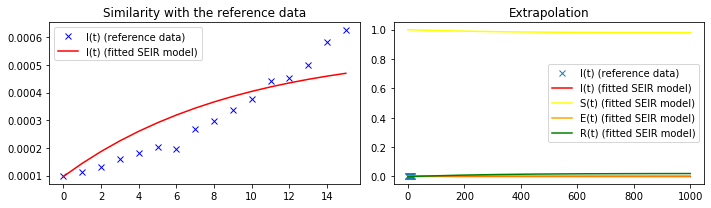

Cumulative number of infected people: 2.0%
Duration before the peak: 39
gamma = 1.7346938775510203
     fun: 0.23325307541060225
     jac: array([ 7.48829916e-04,  1.45537664e+00, -1.03954226e-05])
 message: 'Optimization terminated successfully.'
    nfev: 115
     nit: 21
    njev: 21
 runtime: 8.361817121505737
  status: 0
 success: True
       x: array([1.65347488e-01, 1.00000000e-10, 3.56027535e+00])


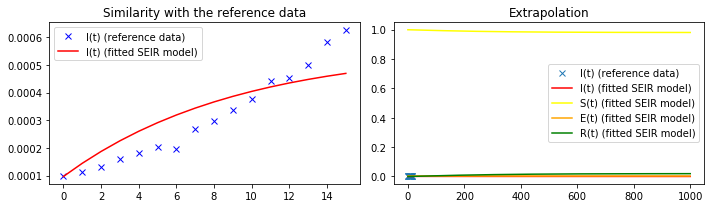

Cumulative number of infected people: 1.9%
Duration before the peak: 38
gamma = 1.836734693877551
     fun: 0.23405998896830355
     jac: array([2.89013982e-02, 1.49752202e+00, 2.22219154e-04])
 message: 'Optimization terminated successfully.'
    nfev: 129
     nit: 24
    njev: 24
 runtime: 10.539812088012695
  status: 0
 success: True
       x: array([1.65150063e-01, 1.00119344e-10, 3.56365238e+00])


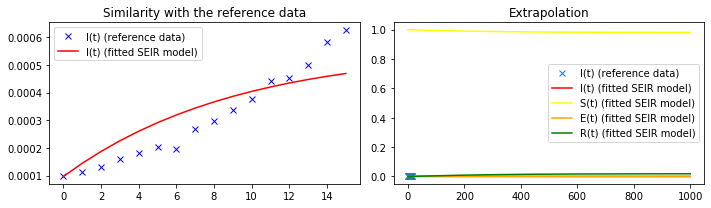

Cumulative number of infected people: 1.8%
Duration before the peak: 37
gamma = 1.9387755102040818
     fun: 0.2348461777365194
     jac: array([-2.29042023e-03,  1.44972189e+00, -1.71177089e-06])
 message: 'Optimization terminated successfully.'
    nfev: 114
     nit: 21
    njev: 21
 runtime: 14.026868104934692
  status: 0
 success: True
       x: array([1.64956766e-01, 1.00000393e-10, 3.56673999e+00])


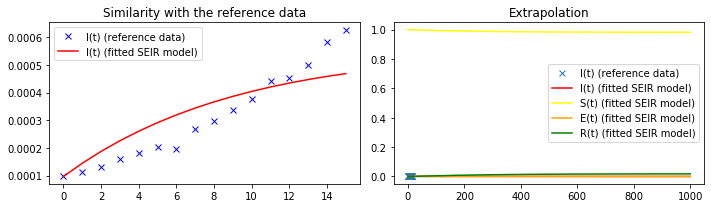

Cumulative number of infected people: 1.8%
Duration before the peak: 36
gamma = 2.0408163265306123
     fun: 0.23561365105551904
     jac: array([2.18676031e-03, 1.45603414e+00, 4.40124422e-05])
 message: 'Optimization terminated successfully.'
    nfev: 112
     nit: 21
    njev: 21
 runtime: 6.158868074417114
  status: 0
 success: True
       x: array([1.64784062e-01, 1.00000000e-10, 3.56969448e+00])


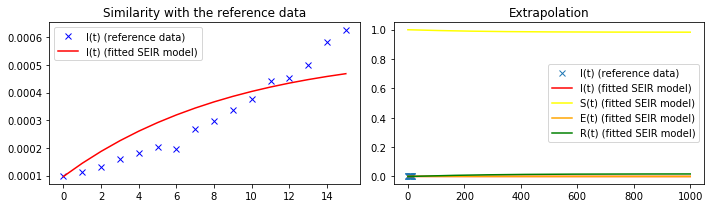

Cumulative number of infected people: 1.7%
Duration before the peak: 36
gamma = 2.142857142857143
     fun: 0.23636411959598994
     jac: array([ 1.18425488e-03,  1.45610476e+00, -6.34528697e-05])
 message: 'Optimization terminated successfully.'
    nfev: 132
     nit: 25
    njev: 25
 runtime: 10.385465145111084
  status: 0
 success: True
       x: array([1.64614447e-01, 1.00003074e-10, 3.57204857e+00])


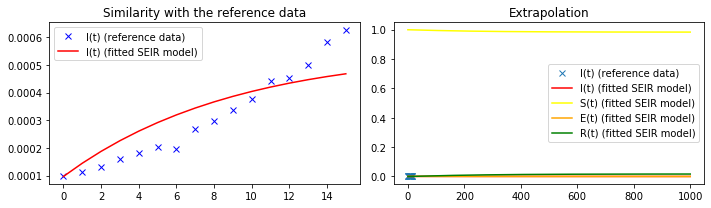

Cumulative number of infected people: 1.7%
Duration before the peak: 35
gamma = 2.2448979591836737
     fun: 0.23709900918506277
     jac: array([2.34528650e-02, 1.49154909e+00, 3.99723649e-06])
 message: 'Optimization terminated successfully.'
    nfev: 98
     nit: 18
    njev: 18
 runtime: 6.4822540283203125
  status: 0
 success: True
       x: array([1.64442234e-01, 1.00000000e-10, 3.57508904e+00])


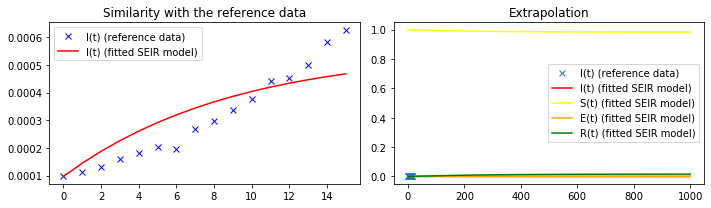

Cumulative number of infected people: 1.6%
Duration before the peak: 35
gamma = 2.3469387755102042
     fun: 0.23781960252026416
     jac: array([ 3.04092877e-02,  1.50465382e+00, -9.39071178e-05])
 message: 'Optimization terminated successfully.'
    nfev: 122
     nit: 22
    njev: 22
 runtime: 4.580233812332153
  status: 0
 success: True
       x: array([1.64288803e-01, 1.00000117e-10, 3.57750687e+00])


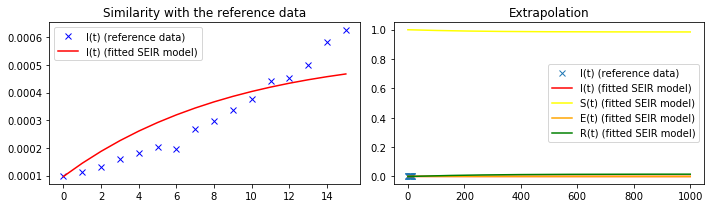

Cumulative number of infected people: 1.6%
Duration before the peak: 34
gamma = 2.4489795918367347
     fun: 0.23852697004065432
     jac: array([5.03849238e-04, 1.45278345e+00, 3.05287540e-06])
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 20
    njev: 20
 runtime: 6.269880056381226
  status: 0
 success: True
       x: array([1.64132144e-01, 1.00000000e-10, 3.58006234e+00])


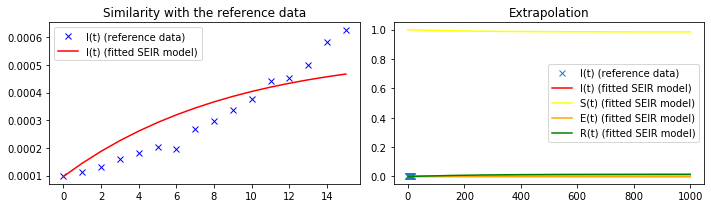

Cumulative number of infected people: 1.5%
Duration before the peak: 34
gamma = 2.5510204081632653
     fun: 0.23922207159380163
     jac: array([-7.95399770e-04,  1.45031631e+00,  1.46403909e-06])
 message: 'Optimization terminated successfully.'
    nfev: 124
     nit: 23
    njev: 23
 runtime: 5.980679988861084
  status: 0
 success: True
       x: array([1.63980371e-01, 1.00000000e-10, 3.58248994e+00])


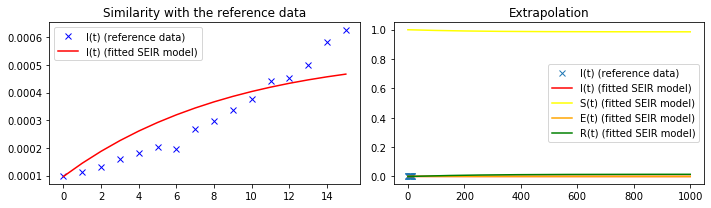

Cumulative number of infected people: 1.5%
Duration before the peak: 33
gamma = 2.6530612244897958
     fun: 642.2930194584657
     jac: array([-1568902.5032196 ,   606047.55130005,   315622.83351898])
 message: 'Optimization terminated successfully.'
    nfev: 161
     nit: 19
    njev: 19
 runtime: 3.468647003173828
  status: 0
 success: True
       x: array([ 3.45057028,  4.17436778, 37.2561732 ])


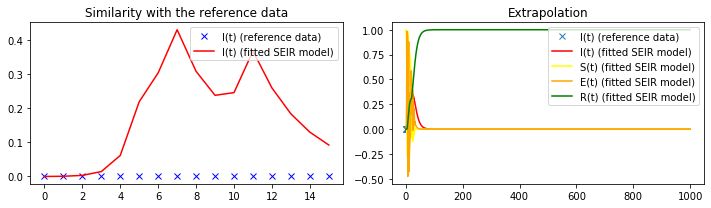

Cumulative number of infected people: 100.0%
Duration before the peak: 7
gamma = 2.7551020408163267
     fun: 0.24057879015775188
     jac: array([8.26291926e-03, 1.46451217e+00, 1.15763396e-05])
 message: 'Optimization terminated successfully.'
    nfev: 112
     nit: 21
    njev: 21
 runtime: 5.679513216018677
  status: 0
 success: True
       x: array([1.63711432e-01, 1.00000000e-10, 3.58672348e+00])


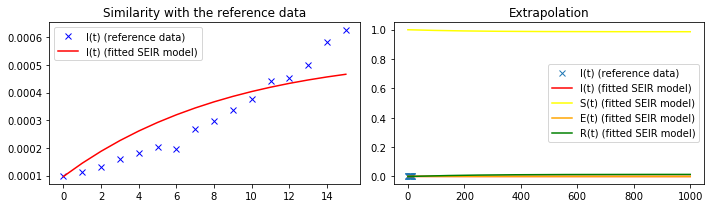

Cumulative number of infected people: 1.4%
Duration before the peak: 32
gamma = 2.857142857142857
     fun: 0.2412416925127592
     jac: array([1.51299872e-03, 1.45287963e+00, 1.38152391e-05])
 message: 'Optimization terminated successfully.'
    nfev: 115
     nit: 22
    njev: 22
 runtime: 6.560430288314819
  status: 0
 success: True
       x: array([1.63560661e-01, 1.00000006e-10, 3.58917494e+00])


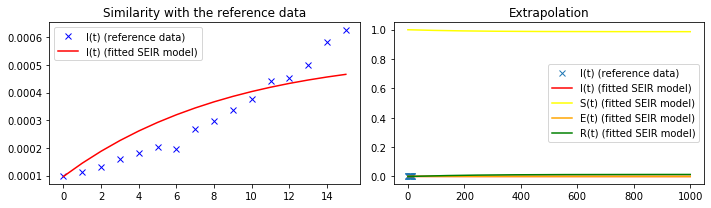

Cumulative number of infected people: 1.4%
Duration before the peak: 32
gamma = 2.9591836734693877
     fun: 0.2418952287782228
     jac: array([ 9.27304849e-04,  1.45184516e+00, -2.00606883e-06])
 message: 'Optimization terminated successfully.'
    nfev: 98
     nit: 18
    njev: 18
 runtime: 9.716027975082397
  status: 0
 success: True
       x: array([1.6342593e-01, 1.0000000e-10, 3.5912425e+00])


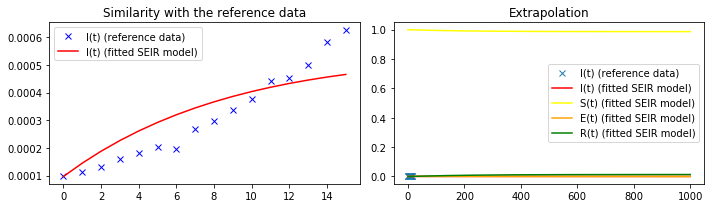

Cumulative number of infected people: 1.3%
Duration before the peak: 32
gamma = 3.0612244897959187
     fun: 0.24253987579862876
     jac: array([ 2.49935072e-02,  1.49262101e+00, -5.75929880e-05])
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 17
    njev: 17
 runtime: 12.41898512840271
  status: 0
 success: True
       x: array([1.63294667e-01, 1.00000000e-10, 3.59331337e+00])


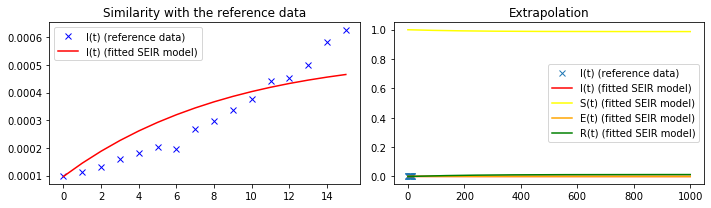

Cumulative number of infected people: 1.3%
Duration before the peak: 31
gamma = 3.163265306122449
     fun: 0.2431761179547279
     jac: array([-8.29802826e-04,  1.44816564e+00, -5.73694706e-07])
 message: 'Optimization terminated successfully.'
    nfev: 121
     nit: 20
    njev: 20
 runtime: 6.286236047744751
  status: 0
 success: True
       x: array([1.63162794e-01, 1.00000000e-10, 3.59539568e+00])


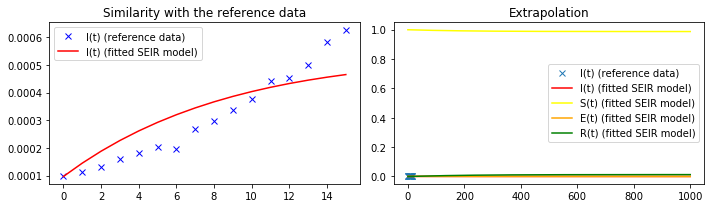

Cumulative number of infected people: 1.3%
Duration before the peak: 31
gamma = 3.2653061224489797
     fun: 0.24380440020720123
     jac: array([2.28003785e-03, 1.45280017e+00, 9.07108188e-06])
 message: 'Optimization terminated successfully.'
    nfev: 122
     nit: 23
    njev: 23
 runtime: 5.833477020263672
  status: 0
 success: True
       x: array([1.63043105e-01, 1.00000000e-10, 3.59727465e+00])


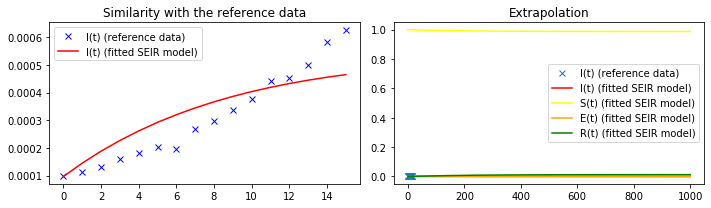

Cumulative number of infected people: 1.2%
Duration before the peak: 31
gamma = 3.36734693877551
     fun: 0.24442511609994944
     jac: array([-2.58953795e-02,  1.40547779e+00,  8.26269388e-06])
 message: 'Optimization terminated successfully.'
    nfev: 136
     nit: 25
    njev: 25
 runtime: 9.498603820800781
  status: 0
 success: True
       x: array([1.62911194e-01, 1.00002169e-10, 3.59933611e+00])


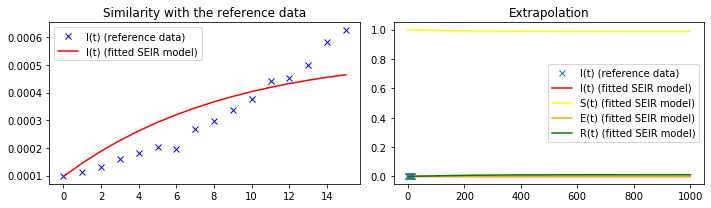

Cumulative number of infected people: 1.2%
Duration before the peak: 30
gamma = 3.4693877551020407
     fun: 0.2450387447516198
     jac: array([ 2.61102058e-03,  1.45635893e+00, -1.88969076e-04])
 message: 'Optimization terminated successfully.'
    nfev: 120
     nit: 22
    njev: 22
 runtime: 11.905829906463623
  status: 0
 success: True
       x: array([1.62808273e-01, 1.00000000e-10, 3.60014393e+00])


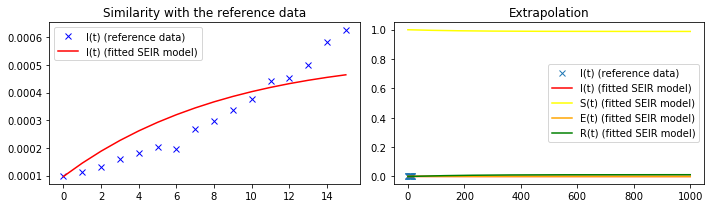

Cumulative number of infected people: 1.2%
Duration before the peak: 30
gamma = 3.5714285714285716
     fun: 0.245645298166528
     jac: array([-1.17428601e-04,  1.44791752e+00, -2.46800482e-06])
 message: 'Optimization terminated successfully.'
    nfev: 130
     nit: 21
    njev: 21
 runtime: 9.384435176849365
  status: 0
 success: True
       x: array([1.62675604e-01, 1.00000019e-10, 3.60297278e+00])


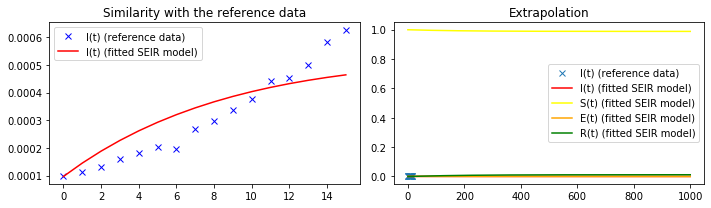

Cumulative number of infected people: 1.2%
Duration before the peak: 30
gamma = 3.673469387755102
     fun: 0.24624542100717284
     jac: array([-1.99414790e-03,  1.44439422e+00, -1.16601586e-06])
 message: 'Optimization terminated successfully.'
    nfev: 109
     nit: 20
    njev: 20
 runtime: 16.40606999397278
  status: 0
 success: True
       x: array([1.62554686e-01, 1.00000000e-10, 3.60487156e+00])


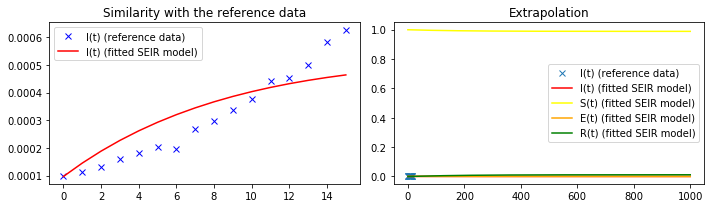

Cumulative number of infected people: 1.1%
Duration before the peak: 30
gamma = 3.7755102040816326
     fun: 0.2468393123751775
     jac: array([-5.91216981e-03,  1.43943876e+00, -1.04302540e-04])
 message: 'Optimization terminated successfully.'
    nfev: 352
     nit: 59
    njev: 58
 runtime: 14.063354730606079
  status: 0
 success: True
       x: array([1.62435794e-01, 1.00000096e-10, 3.60633959e+00])


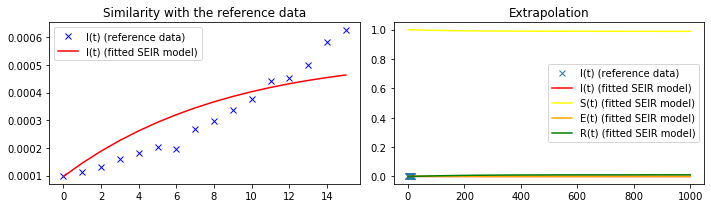

Cumulative number of infected people: 1.1%
Duration before the peak: 30
gamma = 3.8775510204081636
     fun: 0.24742714182932213
     jac: array([-1.43046007e-02,  1.41695973e+00,  3.23811546e-04])
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 19
    njev: 19
 runtime: 5.22375226020813
  status: 0
 success: True
       x: array([1.62330048e-01, 1.00000000e-10, 3.60831400e+00])


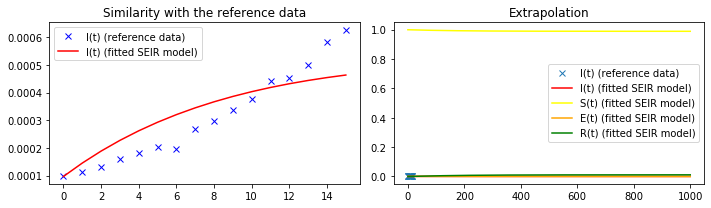

Cumulative number of infected people: 1.1%
Duration before the peak: 29
gamma = 3.979591836734694
     fun: 0.2480092615445859
     jac: array([-1.23939849e-03,  1.44449189e+00,  1.67638063e-06])
 message: 'Optimization terminated successfully.'
    nfev: 123
     nit: 23
    njev: 23
 runtime: 6.840021133422852
  status: 0
 success: True
       x: array([1.62216812e-01, 1.00000000e-10, 3.61008820e+00])


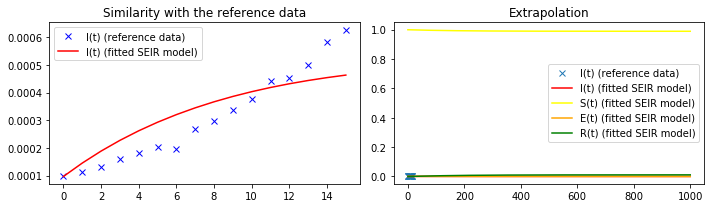

Cumulative number of infected people: 1.1%
Duration before the peak: 29
gamma = 4.081632653061225
     fun: 0.24858586013376788
     jac: array([ 1.59848426e-02,  1.47777801e+00, -2.57860869e-04])
 message: 'Optimization terminated successfully.'
    nfev: 155
     nit: 28
    njev: 28
 runtime: 12.038904190063477
  status: 0
 success: True
       x: array([1.62108386e-01, 1.00000000e-10, 3.61174702e+00])


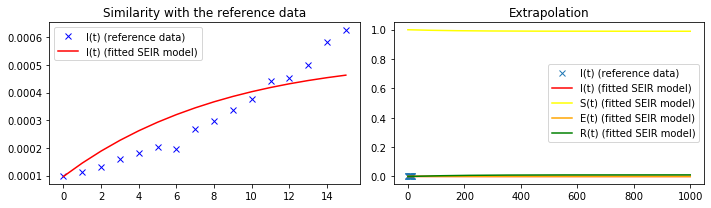

Cumulative number of infected people: 1.1%
Duration before the peak: 29
gamma = 4.183673469387755
     fun: 0.2491571557523183
     jac: array([-7.47498125e-04,  1.44451216e+00,  5.13345003e-06])
 message: 'Optimization terminated successfully.'
    nfev: 114
     nit: 21
    njev: 21
 runtime: 13.015439987182617
  status: 0
 success: True
       x: array([1.61999763e-01, 1.00000065e-10, 3.61342921e+00])


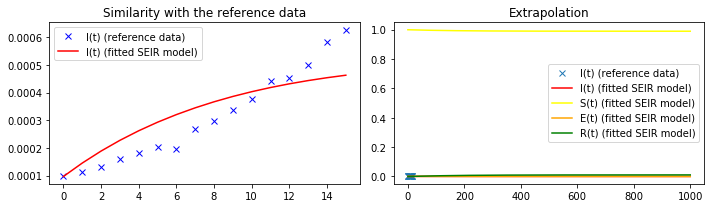

Cumulative number of infected people: 1.1%
Duration before the peak: 29
gamma = 4.285714285714286
     fun: 0.24972334537920846
     jac: array([ 8.01503286e-03,  1.46799008e+00, -4.82166186e-04])
 message: 'Optimization terminated successfully.'
    nfev: 136
     nit: 25
    njev: 25
 runtime: 9.309389114379883
  status: 0
 success: True
       x: array([1.61895009e-01, 1.00000764e-10, 3.61505802e+00])


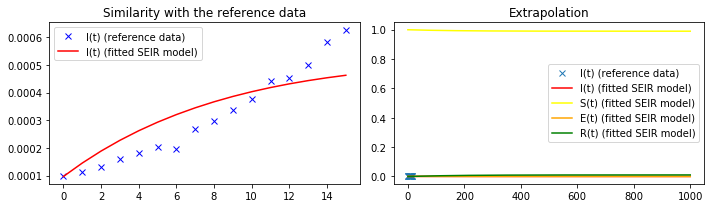

Cumulative number of infected people: 1.0%
Duration before the peak: 29
gamma = 4.387755102040816
     fun: 0.2502846170882212
     jac: array([9.85188782e-03, 1.45137743e+00, 5.37976623e-04])
 message: 'Optimization terminated successfully.'
    nfev: 107
     nit: 20
    njev: 20
 runtime: 6.029896974563599
  status: 0
 success: True
       x: array([1.61790504e-01, 1.00000018e-10, 3.61663983e+00])


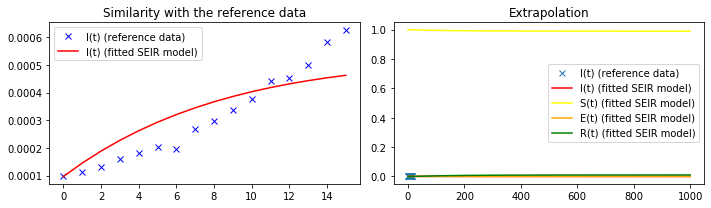

Cumulative number of infected people: 1.0%
Duration before the peak: 28
gamma = 4.4897959183673475
     fun: 0.2508412471016346
     jac: array([-6.19963557e-03,  1.43247887e+00,  1.01793557e-04])
 message: 'Optimization terminated successfully.'
    nfev: 108
     nit: 20
    njev: 20
 runtime: 2.432076930999756
  status: 0
 success: True
       x: array([1.61665812e-01, 1.00005071e-10, 3.61900014e+00])


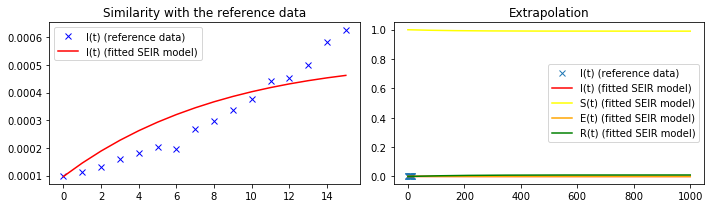

Cumulative number of infected people: 1.0%
Duration before the peak: 28
gamma = 4.591836734693878
     fun: 0.2513930942715265
     jac: array([4.65164706e-03, 1.44087045e+00, 5.95610589e-04])
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 19
    njev: 19
 runtime: 10.141082048416138
  status: 0
 success: True
       x: array([1.61583361e-01, 1.00001537e-10, 3.61975639e+00])


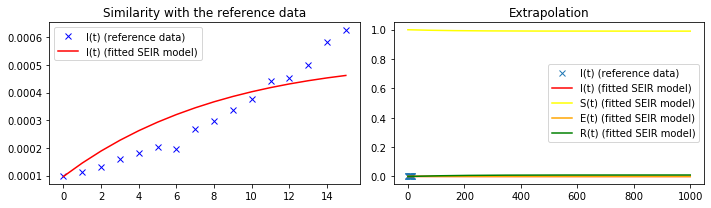

Cumulative number of infected people: 1.0%
Duration before the peak: 28
gamma = 4.6938775510204085
     fun: 0.2519406237843017
     jac: array([-1.91812217e-03,  1.44079425e+00,  2.06381083e-06])
 message: 'Optimization terminated successfully.'
    nfev: 111
     nit: 21
    njev: 21
 runtime: 5.025347948074341
  status: 0
 success: True
       x: array([1.61476521e-01, 1.00000032e-10, 3.62141684e+00])


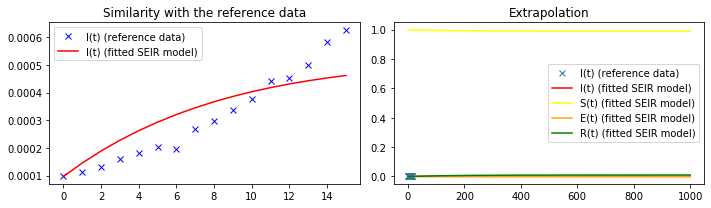

Cumulative number of infected people: 1.0%
Duration before the peak: 28
gamma = 4.795918367346939
     fun: 0.2524838670358789
     jac: array([2.31118239e-02, 1.48205880e+00, 1.21444464e-05])
 message: 'Optimization terminated successfully.'
    nfev: 115
     nit: 21
    njev: 21
 runtime: 10.6045823097229
  status: 0
 success: True
       x: array([1.61383843e-01, 1.00022104e-10, 3.62277782e+00])


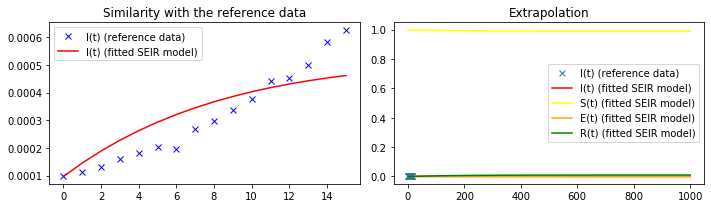

Cumulative number of infected people: 1.0%
Duration before the peak: 28
gamma = 4.8979591836734695
     fun: 0.2530229731653028
     jac: array([-5.91266900e-04,  1.44305937e+00, -3.84636223e-05])
 message: 'Optimization terminated successfully.'
    nfev: 118
     nit: 22
    njev: 22
 runtime: 8.650419235229492
  status: 0
 success: True
       x: array([1.61282130e-01, 1.00000000e-10, 3.62418021e+00])


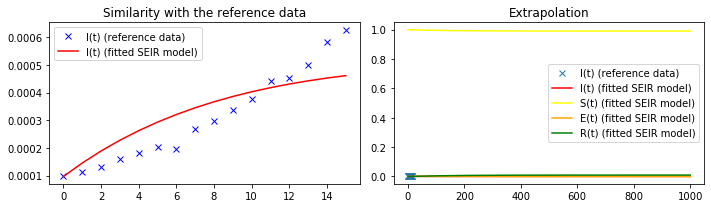

Cumulative number of infected people: 1.0%
Duration before the peak: 28
gamma = 5.0
     fun: 0.2535580643097809
     jac: array([-5.87802380e-04,  1.44200733e+00, -1.53481960e-06])
 message: 'Optimization terminated successfully.'
    nfev: 145
     nit: 27
    njev: 27
 runtime: 9.925586938858032
  status: 0
 success: True
       x: array([1.61182037e-01, 1.00000000e-10, 3.62584886e+00])


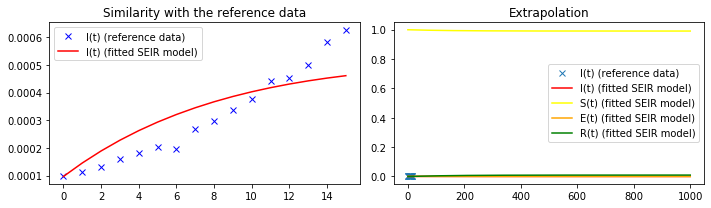

Cumulative number of infected people: 0.9%
Duration before the peak: 28


In [21]:
# Novel data (https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset#covid_19_data.csv)
I_ref = np.array([
    9.66119E-05,
    0.000111821,
    0.000132582,
    0.000158448,
    0.000181343,
    0.000204597,
    0.000196179,
    0.000267507,
    0.000298537,
    0.000335985,
    0.000377149,
    0.000441209,
    0.000453224,
    0.000501478,
    0.000584493,
    0.000627209
])

# Extrapolation window
T = 1000

# Bounds for parameters we need to fit
pe_bounds = (1E-10, 10)
pi_bounds = (1E-10, 10)
exposition_ratio_bounds = (1, 100)

bounds = [pe_bounds, pi_bounds, exposition_ratio_bounds]

n_grid = 1000
n_iter = 50

for gamma in np.linspace(0, 5, 50):
    
    print('gamma = {}'.format(gamma))

    # Regularization methods
    regularization_methods = {
            'pe': 0,
            'pi': 0,
            'max':0,
            'tikhonov': gamma
        }

    extra_parameters = (I_ref, regularization_methods, T)
    
    best_results = random_sample_minimize(J, bounds, extra_parameters, n_grid, n_iter, local_method='SLSQP')

    print(best_results)
    best_pe, best_pi, best_exposition_ratio = best_results['x'][0], best_results['x'][1], best_results['x'][2]

    # Fitted model
    S_list, E_list, I_list, R_list = SEIR(best_exposition_ratio*I_ref[0], I_ref[0], best_pe, best_pi, 6, 10, T)

    # Plot results
    plot_results(I_ref, S_list, E_list, I_list, R_list)
    
    print("Cumulative number of infected people: {}%".format(round(100*R_list[-1], 1)))
    print("Duration before the peak: {}".format(peak(I_list)))
    print('=====================================================================')